In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from tensorflow.keras import layers, models
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import tensorflow as tf
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F

/home/nwertheim/Master-Thesis/thesisenv/bin/python


2025-04-07 09:17:21.397208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 09:17:21.533236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744010241.579831 1488695 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744010241.593380 1488695 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744010241.682394 1488695 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
data_file = os.path.join(univariate_data_path, 'merged_univariate.npy')
data = np.load(data_file, allow_pickle=True)

In [6]:
# Calculate lengths of sequences
lengths = [len(record['signal']) for record in data]
shortest_length = min(lengths)
longest_length = max(lengths)

print(f"Shortest sequence length: {shortest_length}")
print(f"Longest sequence length: {longest_length}")

Shortest sequence length: 1793
Longest sequence length: 1002000


In [5]:
# Function to mask a percentage of data in each window
def mask_data(windows, mask_percentage=0.2):
    masked_windows = windows.copy()
    num_masked = int(mask_percentage * windows.shape[1])
    for i in range(windows.shape[0]):
        mask_indices = np.random.choice(windows.shape[1], num_masked, replace=False)
        masked_windows[i, mask_indices] = np.nan  
    return np.nan_to_num(masked_windows, nan=0.0)


# Create windows from the data
def create_windows(sequence, window_size, step_size):
    windows = [sequence[i:i+window_size] for i in range(0, len(sequence) - window_size + 1, step_size)]
    return np.array(windows)

# Set windowing parameters
window_size = 5000
step_size = 2500

# Process each record and apply windowing
all_windows = [create_windows(record['signal'], window_size, step_size) for record in data]
all_windows = np.concatenate(all_windows, axis=0)
# Reshape for Conv1D (batch_size, time_steps, channels)
all_windows = np.expand_dims(all_windows, axis=-1)  
print(f"Processed window shape: {all_windows.shape}")

# Perform an 80-10-10 split
X_train, X_temp = train_test_split(all_windows, test_size=0.2, random_state=42)  # First split (80% train, 20% temp)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)  # Split temp into 10% val, 10% test

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 300 has 1 dimension(s)

In [4]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
# import optuna

# # Define the LSTM Autoencoder
# class LSTMAutoencoder(nn.Module):
#     def __init__(self, input_dim=1, hidden_dim=64, num_layers=2):
#         super(LSTMAutoencoder, self).__init__()
        
#         # Encoder
#         self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
#         # Decoder
#         self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        
#         self.output_layer = nn.Linear(hidden_dim, input_dim)
        
#     def forward(self, x):
#         encoded, (hidden, cell) = self.encoder(x)
#         decoded, _ = self.decoder(encoded, (hidden, cell))
#         output = self.output_layer(decoded)
#         return output

# # Function to mask a percentage of data in each window
# def mask_data(windows, mask_percentage=0.2):
#     masked_windows = windows.clone()
#     num_masked = int(mask_percentage * windows.shape[1])
#     for i in range(windows.shape[0]):
#         mask_indices = np.random.choice(windows.shape[1], num_masked, replace=False)
#         masked_windows[i, mask_indices, :] = 0.0  # Ensure correct shape
#     return masked_windows

# # Define objective function for Optuna optimization
# def objective(trial):
#     # Sample hyperparameters
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
#     mask_percentage = trial.suggest_uniform('masking_ratio', 0.1, 0.5)
#     num_layers = trial.suggest_int('num_layers', 1, 3)
#     hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128])
    
#     # Split data into train, validation, and test sets
#     X_train, X_temp = train_test_split(all_windows, test_size=0.2, random_state=42)
#     X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)
    
#     # Convert data to PyTorch tensors
#     X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#     X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

#     # Create DataLoader
#     train_dataset = TensorDataset(X_train_tensor)
#     val_dataset = TensorDataset(X_val_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
#     # Initialize model, loss function, and optimizer
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print('device:', device)
#     model = LSTMAutoencoder(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     # Training loop
#     num_epochs = 5
#     best_val_loss = float('inf')
    
#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
        
#         for batch in train_loader:
#             inputs = batch[0].to(device)
#             masked_inputs = mask_data(inputs, mask_percentage=mask_percentage)
            
#             optimizer.zero_grad()
#             outputs = model(masked_inputs)
#             loss = criterion(outputs, inputs)
#             loss.backward()
#             optimizer.step()
            
#             total_train_loss += loss.item()
        
#         # Validation loop
#         model.eval()
#         total_val_loss = 0
#         with torch.no_grad():
#             for batch in val_loader:
#                 inputs = batch[0].to(device)
#                 masked_inputs = mask_data(inputs, mask_percentage=mask_percentage)
                
#                 outputs = model(masked_inputs)
#                 loss = criterion(outputs, inputs)
#                 total_val_loss += loss.item()
        
#         avg_val_loss = total_val_loss / len(val_loader)
        
#         # Update best validation loss
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss

#     # Log hyperparameters and validation loss
#     with open("optuna_results.txt", "a") as f:
#         f.write(f"Trial {trial.number}: learning_rate={learning_rate}, batch_size={batch_size}, "
#                 f"masking_ratio={mask_percentage}, num_layers={num_layers}, hidden_dim={hidden_dim}, "
#                 f"validation_loss={best_val_loss:.6f}\n")

#     return best_val_loss  # Minimize the validation loss

# # Use Optuna to perform Bayesian optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # Print the best hyperparameters
# print('Best hyperparameters:', study.best_params)


Using device: cuda
Epoch 1/20, Train Loss: 0.212614, Test Loss: 0.019614
Epoch 2/20, Train Loss: 0.056993, Test Loss: 0.016067
Epoch 3/20, Train Loss: 0.034310, Test Loss: 0.025230
Epoch 4/20, Train Loss: 0.028113, Test Loss: 0.021502
Epoch 5/20, Train Loss: 0.022626, Test Loss: 0.005087
Epoch 6/20, Train Loss: 0.022203, Test Loss: 0.005189
Epoch 7/20, Train Loss: 0.017158, Test Loss: 0.003495
Epoch 8/20, Train Loss: 0.016361, Test Loss: 0.016553
Epoch 9/20, Train Loss: 0.019880, Test Loss: 0.005367
Epoch 10/20, Train Loss: 0.012969, Test Loss: 0.008686
Epoch 11/20, Train Loss: 0.014549, Test Loss: 0.003556
Epoch 12/20, Train Loss: 0.012188, Test Loss: 0.004068
Epoch 13/20, Train Loss: 0.011643, Test Loss: 0.003877
Epoch 14/20, Train Loss: 0.010910, Test Loss: 0.006595
Epoch 15/20, Train Loss: 0.010606, Test Loss: 0.003198
Epoch 16/20, Train Loss: 0.009456, Test Loss: 0.003937
Epoch 17/20, Train Loss: 0.011910, Test Loss: 0.004264
Epoch 18/20, Train Loss: 0.008984, Test Loss: 0.002762


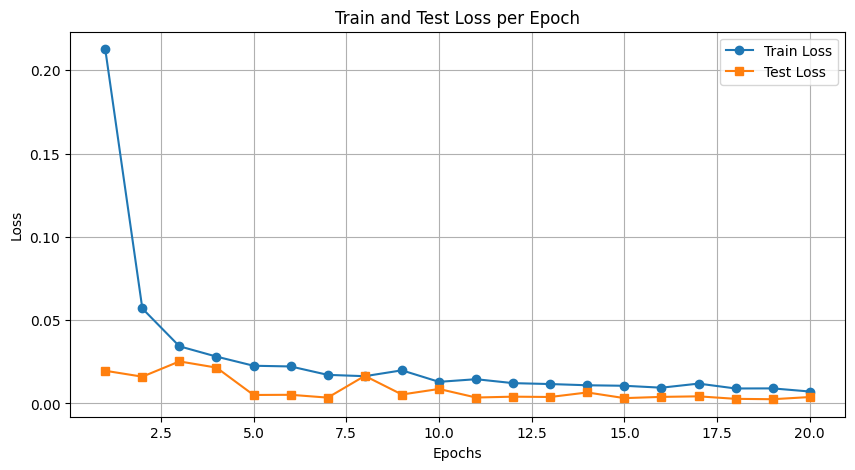

Encoder model saved to ../models/final_encoder_model.pth


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Define the LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        encoded, (hidden, cell) = self.encoder(x)
        decoded, _ = self.decoder(encoded, (hidden, cell))
        output = self.output_layer(decoded)
        return output

# Function to mask a percentage of data in each window
def mask_data(windows, mask_percentage=0.11056357448720136):
    masked_windows = windows.clone()
    num_masked = int(mask_percentage * windows.shape[1])
    for i in range(windows.shape[0]):
        mask_indices = np.random.choice(windows.shape[1], num_masked, replace=False)
        masked_windows[i, mask_indices, :] = 0.0  
    return masked_windows

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Recreate the dataset splits
X_train, X_temp = train_test_split(all_windows, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Merge train and validation sets
X_train_combined = np.concatenate([X_train, X_val])

# Convert to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
model = LSTMAutoencoder(input_dim=1, hidden_dim=128, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00048656852885165864)

# Training loop
num_epochs = 20
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        inputs = batch[0].to(device)  # Move batch to GPU
        masked_inputs = mask_data(inputs)  # Ensure masking happens on GPU
        
        optimizer.zero_grad()
        outputs = model(masked_inputs)
        loss = criterion(outputs, inputs)  # Compute loss on GPU
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Testing loop
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)  # Move batch to GPU
            masked_inputs = mask_data(inputs)
            
            outputs = model(masked_inputs)
            loss = criterion(outputs, inputs)  # Compute loss on GPU
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

# Move losses back to CPU for plotting
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

# Extract and save the encoder model
encoder_model = model.encoder  # Extract only the encoder part
save_location = os.path.join(models_path, 'final_encoder_model.pth')

# Save the encoder
torch.save(encoder_model.state_dict(), save_location)
print(f"Encoder model saved to {save_location}")
